# Aplicação de técnicas de NLP e Aprendizado de máquina para realizar o reconhecimento de entidades por modelagem de tópicos

In [1]:
import pandas as pd
import numpy as np
import regex as re
import string
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from minisom import MiniSom 


## 1. Importando dados da preparação e stopwords

In [2]:
PARQUET_INFORMACOES_PREPARADAS = '../../Data/Processed/informacoes_preparadas.parquet'

df= pd.read_parquet(PARQUET_INFORMACOES_PREPARADAS)

In [3]:
df.head()

,Titulo,Texto,Topico
0,Despachos SCG/ANEEL nº 1500 1.501 1.503 1.5...,levamos ao conhecimento os despachos scg/aneel...,Alteração das características técnicas
1,Resoluções Autorizativas ANEEL nº 6.375 nº 6....,levamos ao conhecimento as resoluções autoriza...,Outorga
2,Resoluções Autorizativas ANEEL nº 6.375 nº 6....,levamos ao conhecimento as resoluções autoriza...,Outros
3,Resolução Autorizativa ANEEL nº 6.401,levamos ao conhecimento a resolução autorizati...,Outros
4,Resolução Autorizativa ANEEL nº 6.402,levamos ao conhecimento a resolução autorizati...,Outros


In [4]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [24]:
df2 = df[df['Topico'] !=  'Outros']

In [25]:
df2

,Titulo,Texto,Topico
0,Despachos SCG/ANEEL nº 1500 1.501 1.503 1.5...,levamos ao conhecimento os despachos scg/aneel...,Alteração das características técnicas
1,Resoluções Autorizativas ANEEL nº 6.375 nº 6....,levamos ao conhecimento as resoluções autoriza...,Outorga
10,Despacho SFG/ANEEL nº 1.614,levamos ao conhecimento o despacho sfg/aneel n...,Entrada em operação
11,Despacho SFG/ANEEL nº 1.615,levamos ao conhecimento o despacho sfg/aneel n...,Entrada em operação
13,Despachos SCG/ANEEL nº 1508 1.509 1.510 1.5...,levamos ao conhecimento os despachos scg/aneel...,Alteração das características técnicas
...,...,...,...
27541,DESPACHOS SFG/ANEEL Nº 843 851 E 852 DE 29 M...,decisão: liberar as unidades geradoras para in...,Entrada em operação
27542,DESPACHOS SFG/ANEEL Nº 843 851 E 852 DE 29 M...,decisão: liberar as unidades geradoras para in...,Entrada em Operação Comercial
27543,DESPACHOS SFG/ANEEL Nº 843 851 E 852 DE 29 M...,decisão: liberar as unidades geradoras para in...,Entrada em Operação Teste
27544,DESPACHO SCG/ANEEL Nº 849 DE 29 DE MARÇO DE 2022,processos nº: 48500.003718/2019-61 e 48100.001...,Alteração das características técnicas


In [43]:
documents = df2.Texto.values 

no_features = 3000

tfidf_vector = TfidfVectorizer(max_df=0.95, min_df=10,
                               max_features=no_features,
                               stop_words=stopwords,
                               )

tfidf = tfidf_vector.fit_transform(documents)

tfidf_feature_names = tfidf_vector.get_feature_names_out()

In [44]:
D = tfidf.todense().tolist()

In [45]:
pd.DataFrame(D, columns=tfidf_feature_names).head()

,00,000,0001,000kw,001,001520,002,003,003031,003807,...,íntegra,íntegras,óleo,órgão,órgãos,ótimo,ônus,última,único,úteis
0,0.0,0.038482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024083,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085546,0.0
2,0.0,0.081819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051205,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044272,0.0
4,0.0,0.031035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019423,0.0


In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
D = scaler.fit_transform(D)

In [47]:
n_neurons = 5
m_neurons = 5

som = MiniSom(n_neurons, m_neurons, no_features)
som.pca_weights_init(D)

som.train(D, 15000, random_order=True, verbose=True)

C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\minisom.py:379: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


 [ 15000 / 15000 ] 100% - 0:00:00 left 
 quantization error: 49.051688066406115


In [48]:
top_keywords = 10

codebook = som.get_weights()

count = 1
for idx in range(n_neurons):
    for jdx in range(m_neurons):
        keywords_list_idx = np.argsort(codebook[idx, jdx, :])[-top_keywords:]
        keywords = ' '.join([tfidf_feature_names[n] for n in keywords_list_idx])
        print(f"Topico {count}: {keywords}")
        count += 1

Topico 1: infracionais equiparáveis oferecida inidoneidade comprobatórias tipificadas reabilitação alcançam atenuantes prestada
Topico 2: poderá importações notificada tipo ato aquisição instrução pessoa considerado jurídica
Topico 3: referentes mês concessionárias fontes eletrobrás quotas proinfa incentivo custeio alternativas
Topico 4: acompanhar remunerada analisar governança entidades membros voto ordinário maioria quórum
Topico 5: 590 digital instrução apresentar 48340 governo superiores estrutura economia elaborar
Topico 6: debêntures alocar evidenciem destacar captados restritos anúncio prospecto jurisdição 7ª
Topico 7: requeridos ensejarão cuja definitivo spde 274 razoabilidade atestada alcançado aliança
Topico 8: usuários outras mre anuência eficácia srg mitigação risco repactuação hidrológico
Topico 9: custo tratam média participar proveniente custos compensação tarifa desde ordem
Topico 10: angra imposta considerada tarifa trezentos setenta mensalmente reais mwh centavos
Top

In [49]:
map_categories = {v: k for k, v in enumerate(df2.Topico.unique())}
labels = df2.Topico.unique()

target = [map_categories[l] for l in df2.Topico.values]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

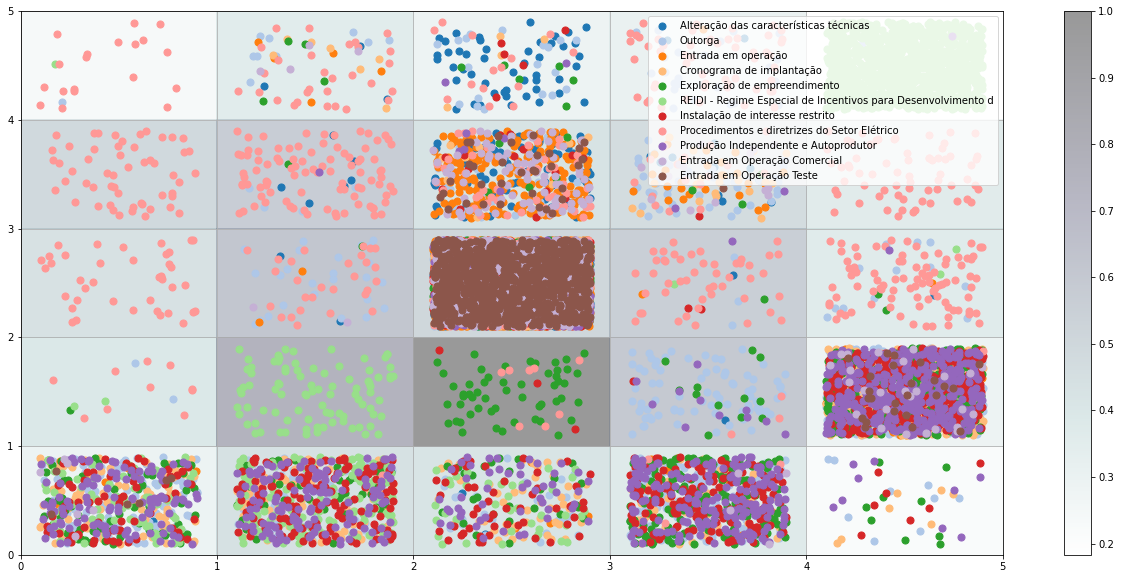

In [54]:
winners = [som.winner(doc) for doc in D]

plt.figure(figsize=(22, 10))
plt.pcolor(som.distance_map().T, cmap="bone_r", alpha=.4)
plt.colorbar()

w_x, w_y = zip(*winners)
w_x = np.array(w_x)
w_y = np.array(w_y)


colors = [plt.cm.tab10(0),plt.cm.tab10(1),plt.cm.tab10(2),
          plt.cm.tab10(3),plt.cm.tab10(4)]

for t in np.unique(target):
    idx_target = target == t
    plt.scatter(w_x[idx_target] + 0.5 + ( np.random.rand(len(w_x[idx_target])) -.5) * .8,
                w_y[idx_target] + 0.5 + ( np.random.rand(len( w_y[idx_target] )) -.5) * .8,
                s=50,
                c=plt.cm.tab20(t),
                label=labels[t])
plt.legend(loc='upper right')
plt.grid()

## 2. Vetorizando com tf-idf

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

### 2.1 Verificando o vocabulário da tokenização

In [17]:
vocab = np.array(tfidf_feature_names)

### Como o interesse é o de identificar entidades, técnicas como a de lemetização não são interessantes, pois poderiam diminuir a quantidade de informações de interesse. Podemos identificar também que muitas palavras poderiam ainda ser eliminadas como stopwords e este processo poderia se repetir por muitas vezes. A título de exercício vamos continuar o processamento com todas as palavras vetorizadas.

## 3. Modelagem de tópicos com NMF

Fatoração de matriz não negativa (NMF) é uma técnica não supervisionada, logo, não há rotulagem de tópicos nos quais o modelo será treinado. O NMF decompõe vetores de dimensões elevadas em uma representação de dimensões inferiores. Esses vetores de dimensão inferior são não negativos, o que também significa que seus coeficientes não são negativos.

Usando a matriz original (X), o NMF fornecerá duas matrizes (W e H), onde:
 * W são os tópicos encontrados 
 * H são os coeficientes (pesos) para esses tópicos. 

Em outras palavras: X são documentos por palavras (original), H são documentos por tópicos e W são tópicos por palavras.

Para o nosso caso, assumindo 3491 documentos, 2892 palavras e 30 tópicos, obteríamos as seguintes 3 matrizes:

X = tfidf_vectorizer.transform(textos dos documentos)<br>
W = nmf.components_<br>
H = nmf.transform(X)<br>
X = 3491 x 2892<br>
W = 3491 x 30<br>
H = 30 x 2892<br>

O NMF modificará os valores iniciais de W e H para que o produto se aproxime de A até que o erro de aproximação convirja ou as iterações máximas sejam alcançadas.

Em nosso caso, os vetores de alta dimensão serão pesos tf-idf, mas podem ser qualquer coisa, incluindo vetores de palavras ou uma simples contagem bruta de palavras.

### 3.1 Uso de NMF para 10 tópicos, 10 palavras por tópico

In [19]:
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [20]:
# Quantidade de palavras nos tópicos
num_top_words=10

model_nmf = NMF(n_components=10, max_iter=350, init='nndsvd')

W = model_nmf.fit_transform(tfidf)

H = model_nmf.components_

print(show_topics(H))

['art nº geradora resolução ufv central início 1996 sob lei', 'kw geração liberar conferidas capacidade totalizando 22 aneel titularidade outubro', 'mme portaria interessada nº desenvolvimento art objeto reidi planejamento encontra', 'portaria projeto art autorizada implantação 1º início nesta federal nº', 'aneel energia diretor transmissão interposto nº elétrica geral 48500 pepitone', 'ventos eol santa localização geradoras unidades interessados 00 usina modalidade', 'cvu ute termelétrica termopernambuco usina determinar custo valor unitário contabilização', 'pública participação subsídios contribuições gov envio br obter aneel menu', 'art nº resolução 1º anexo lei inciso artigo 2º decreto', 'alterar kv ufv nº transmissão sob 138 potência despacho subestação']


### 3.2 Visulização de tópicos com NMF e LDA [LatentDirichletAllocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) por Olivier Grisel <olivier.grisel@ensta.org>, Lars Buitinck e Chyi-Kwei Yau <chyikwei.yau@gmail.com>

3491 Documentos, 2892 palavras, 10 tópicos e 20 top palavras

Extracting tf-idf features for NMF...
done in 7.763s.
Extracting tf features for LDA...
done in 6.890s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=4000 and n_features=2000...


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


done in 11.681s.


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


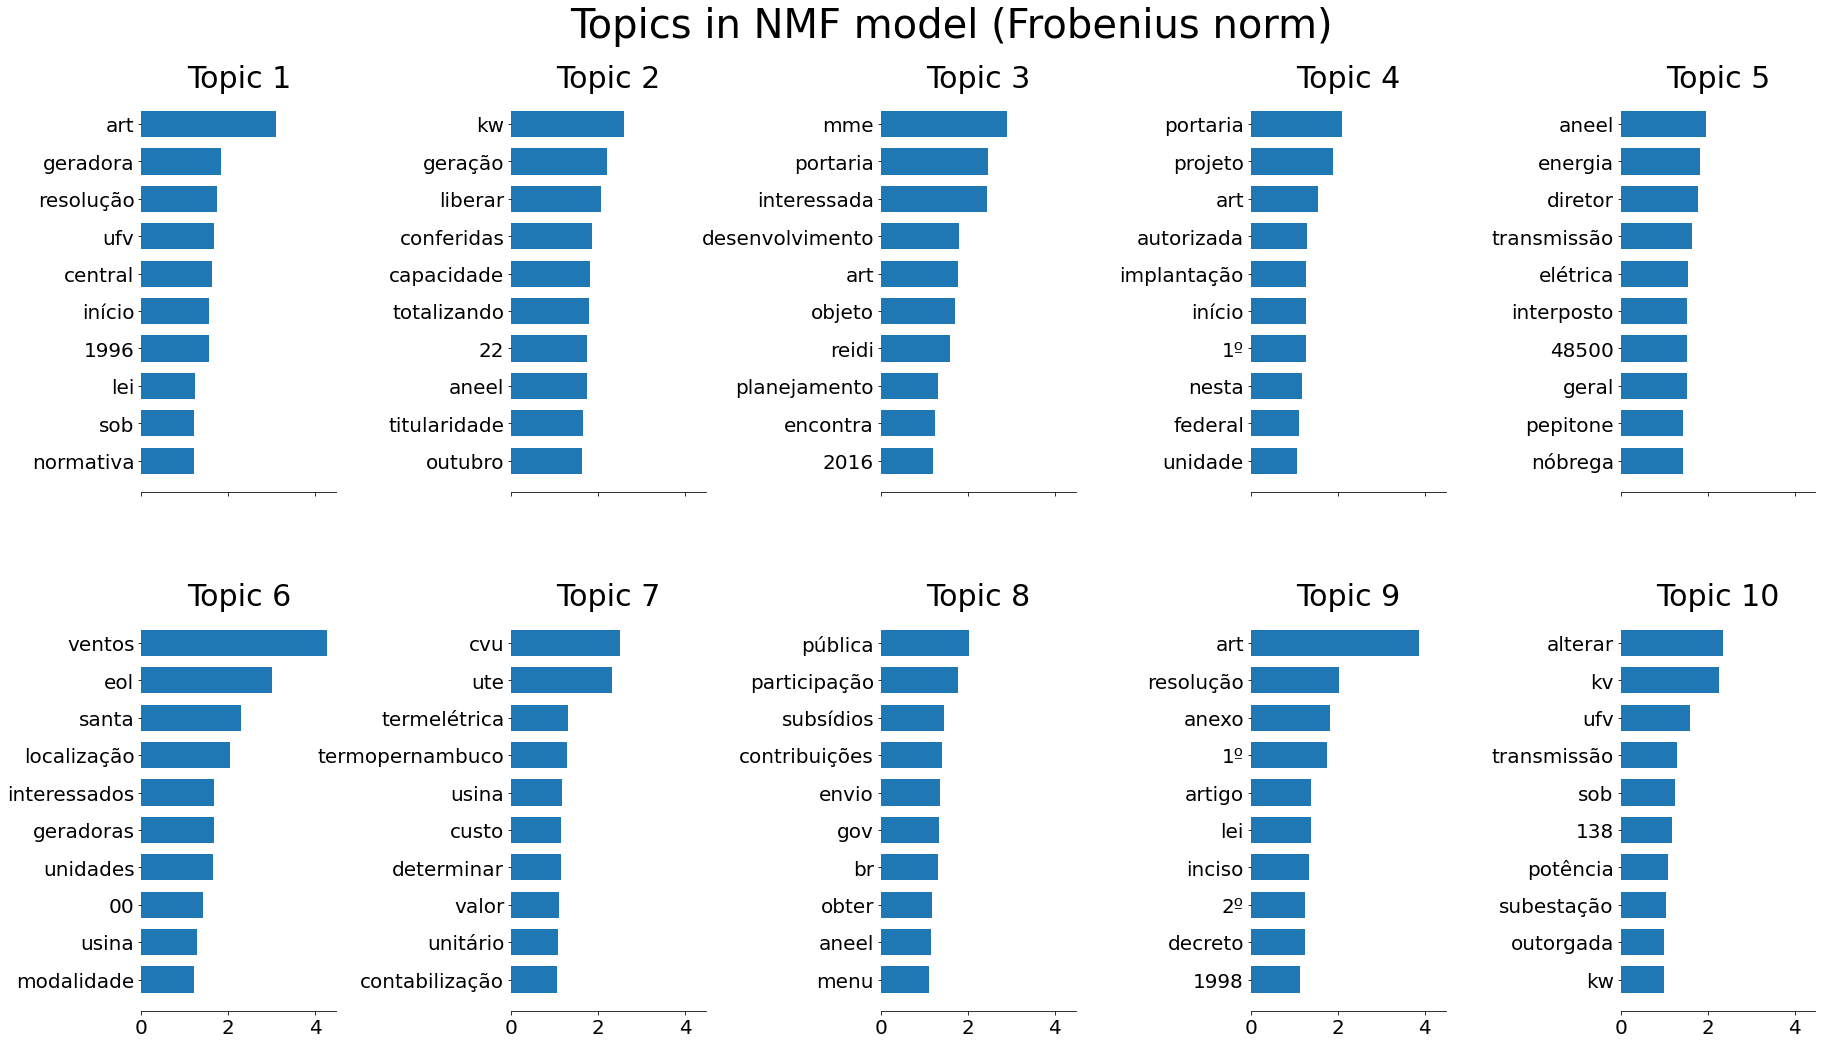



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=4000 and n_features=2000...


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


done in 137.012s.


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


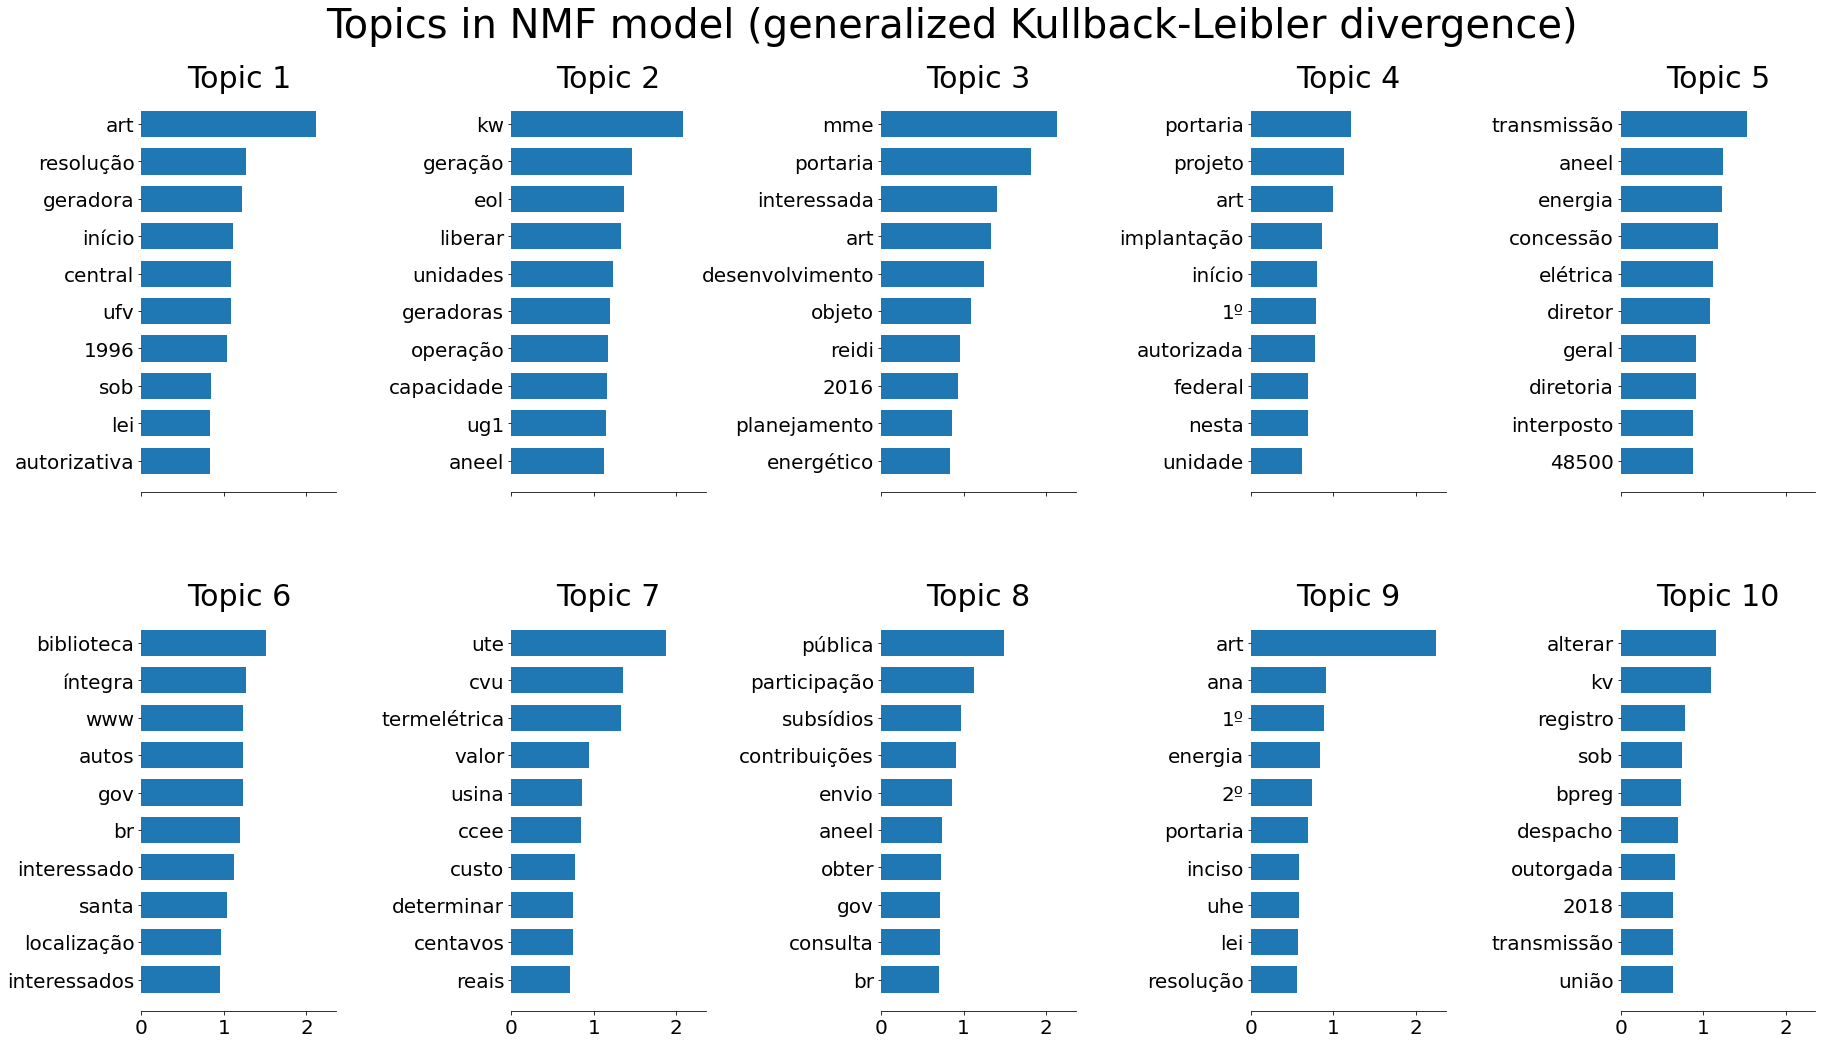



 Fitting LDA models with tf features, n_samples=4000 and n_features=2000...
done in 63.888s.


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


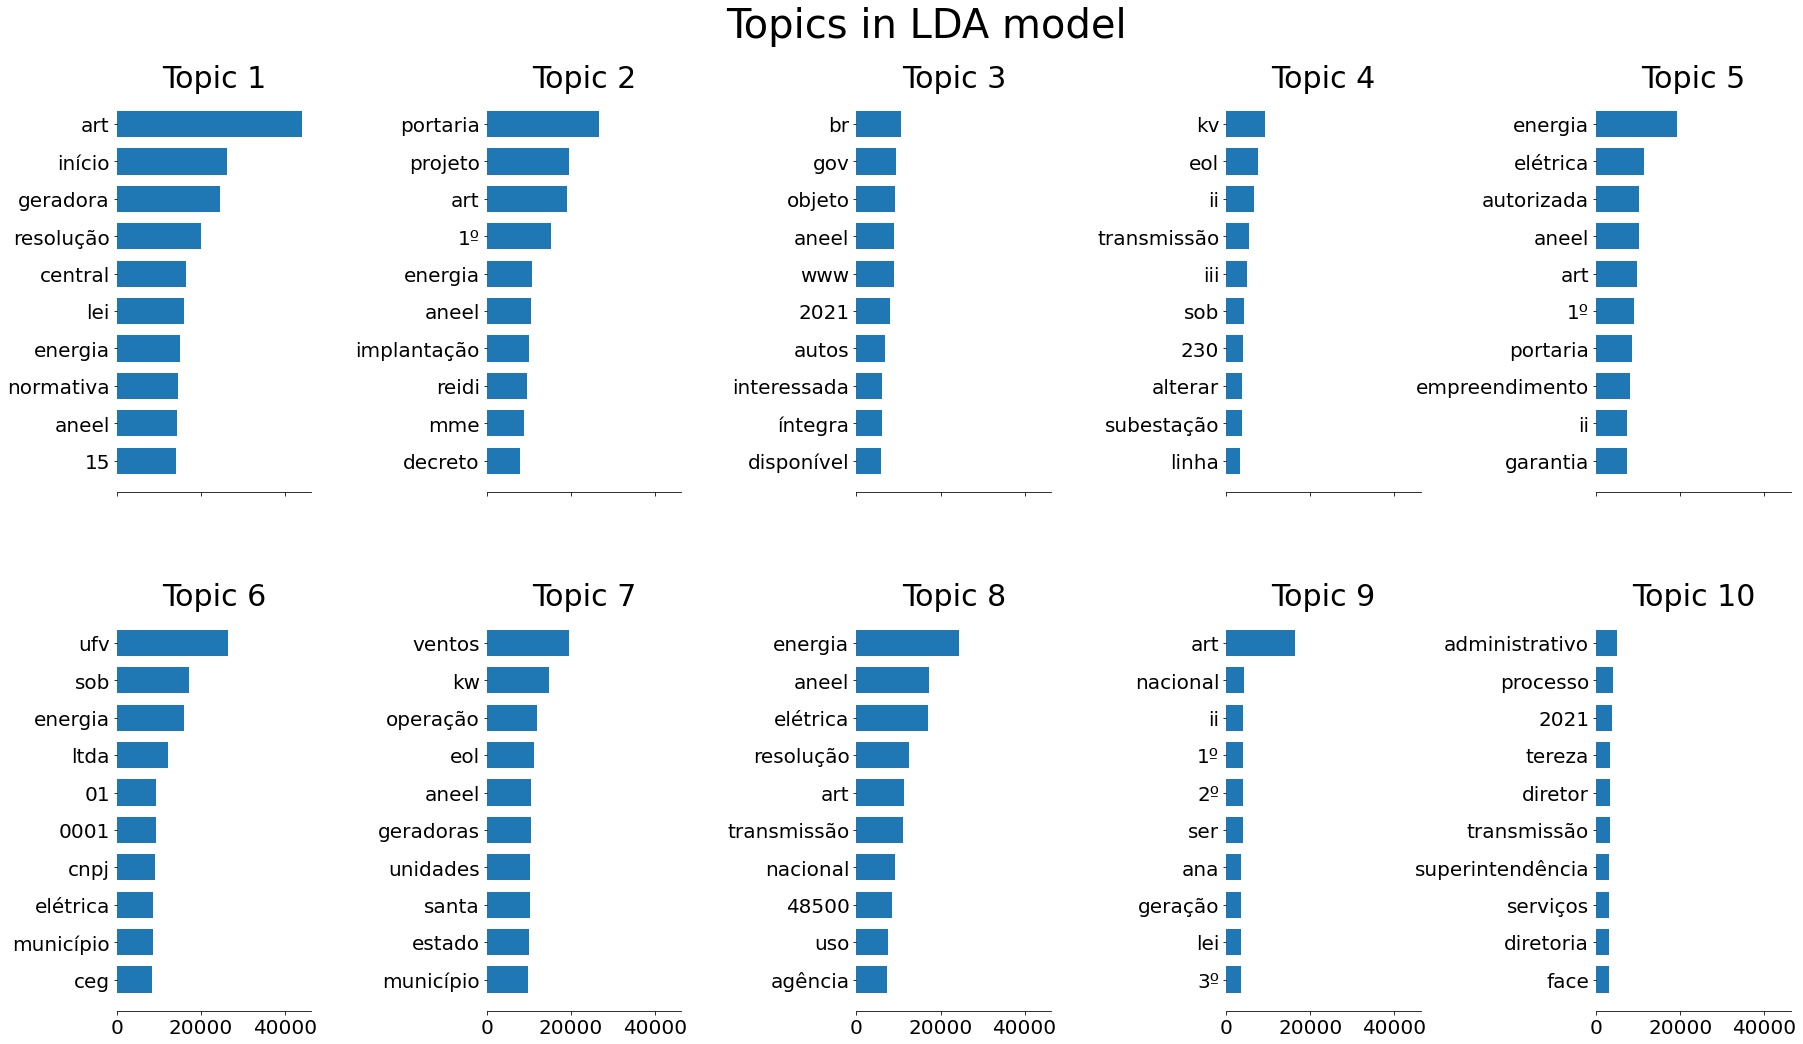

In [22]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 4000
n_features = 2000
n_components = 10
n_top_words = 10

# Adaptação do data_sample
data_samples = (df['Texto'])

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=3,
                                     max_features=n_features,
                                     stop_words=stopwords)

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.90, min_df=3,
                                # max_features=n_features,
                                stop_words=stopwords)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5, init = 'nndsvda').fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

## 4. Clusterização por KNN 

In [28]:
km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=10, verbose=True)

km.fit_transform(D)

print(show_topics(km.cluster_centers_))

Initialization complete
Iteration 0, inertia 261102161.76527584
Iteration 1, inertia 193110983.4249088
Iteration 2, inertia 192315353.95162722
Iteration 3, inertia 191896361.48063576
Iteration 4, inertia 191779572.82836202
Iteration 5, inertia 191624699.9919414
Iteration 6, inertia 191567296.76138896
Iteration 7, inertia 191528236.3309846
Iteration 8, inertia 191465593.19541448
Iteration 9, inertia 191415355.08291242
Iteration 10, inertia 191360678.72231776
Iteration 11, inertia 191293303.61320445
Iteration 12, inertia 191284874.34876826
Iteration 13, inertia 191284292.1459716
Iteration 14, inertia 191283331.87006208
Iteration 15, inertia 191282738.0508015
Iteration 16, inertia 191282567.8731302
Iteration 17, inertia 191282375.80236542
Iteration 18, inertia 191282333.15031457
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 269509849.57911897
Iteration 1, inertia 194796922.1195532
Iteration 2, inertia 194260341.41519153
Iteration 3, inertia 19

### 4.1 Organização dos clusters

In [29]:
from collections import Counter
c = Counter(km.labels_)
c

Counter({6: 12683,
         5: 15715,
         3: 494,
         1: 87,
         0: 2087,
         4: 3576,
         9: 2487,
         8: 1813,
         7: 352,
         2: 678})